# Кошелев Александр

# Imports

In [87]:
import gym
from gym import spaces
from gym.utils import seeding
import matplotlib.pyplot as plt
from abc import ABC, abstractmethod
from loguru import logger
from collections import defaultdict
from copy import deepcopy

In [88]:
def moving_average(x, w):
    return np.convolve(x, np.ones(w), 'valid') / w

In [246]:
class BlackJackGamer(ABC):
    
    def __init__(self,  env) -> None:
        self.env = env
        
    @abstractmethod
    def run_episode(self):
        ...
             
    @abstractmethod
    def policy(self, observation, epsilon) -> int:
        ...
        
    @abstractmethod
    def evaluate_episode(self):
        ...

# Пункт 1

In [176]:
env = gym.make("Blackjack-v1")
env.reset()

(16, 10, False)

## Simple Player

In [247]:
class SimplePlayer(BlackJackGamer):
    
    def run_episode(self):
        states, actions, rewards = [], [], []
        observation = self.env.reset()
        while True:
            states.append(observation)
            action = self.policy(observation)
            actions.append(action)
            observation, reward, done, info = self.env.step(action)
            rewards.append(reward)
            if done:
                return states, actions, rewards
            
    def policy(self, observation, epsilon=0) -> int:
        score, dealer_score, usable_ace = observation
        return 0 if score >= 19 else 1
    
    def evaluate_episode(self):
        states, actions, rewards = [], [], []
        observation = self.env.reset()
        while True:
            states.append(observation)
            action = self.policy(observation, 0)
            actions.append(action)
            observation, reward, done, info = self.env.step(action)
            rewards.append(reward)
            if done:
                return states, actions, rewards 

In [248]:
simple_player = SimplePlayer(env)

In [249]:
states, actions, rewards = simple_player.run_episode()

In [250]:
gain = []
for _ in range(300000):
    states, actions, rewards = simple_player.run_episode()
    gain.append(rewards[-1])

In [251]:
gain_eval = []
for _ in range(100000):
    states, actions, rewards = simple_player.evaluate_episode()
    gain_eval.append(rewards[-1])

In [191]:
np.mean(gain_eval)

-0.19529

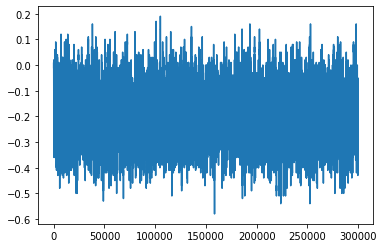

In [192]:
# plt.plot(gain_n.mean(axis=dd1)[:100])
plt.plot(moving_average(gain, 100))

## Q-learning Player

In [252]:
class QLearningPlayer(BlackJackGamer):
    
    def __init__(self, env, lr, gamma) -> None:
        super(QLearningPlayer, self).__init__(env)
        self.Q = {}
        self.lr = lr
        self.gamma = gamma
        
    def init_random_Q(self):
        self.Q = {}
        for i in range(12):
            self.Q[i] = np.array([0, 1])
        for i in range(22, 32):
            self.Q[i] = np.array([0, 0])
        for i in range(12, 22):
            self.Q[i] = np.random.random(2)
        self.Q[21][1] = 0
        self.Q[21][0] = 1
        
            
    def run_episode(self):
        states, actions, rewards = [], [], []
        observation = self.env.reset()
        s, _, __ = observation 
        action = self.policy(observation, cnt)
        while True:
            states.append(s)        
            actions.append(action)
            observation, reward, done, info = self.env.step(action)
            s_prime, _, __ = observation
            a_prime = self.policy(observation)
            if s > 12 and s < 21:
                self.Q[s][action] = self.Q[s][action] + self.lr * (reward + self.gamma * np.max(self.Q[s_prime]) - self.Q[s][action])
            s, action = s_prime, a_prime
            rewards.append(reward)
            if done:
                return states, actions, rewards              
    
    def policy(self, observation, epsilon=0.1) -> int:
        score, dealer_score, usable_ace = observation
        if score > 21:
            return 0
        if np.random.random() < epsilon:
            return np.random.choice([0, 1]) 
        return np.argmax(self.Q[score])
    
    def evaluate_episode(self):
        states, actions, rewards = [], [], []
        observation = self.env.reset()
        while True:
            states.append(observation)
            action = self.policy(observation, 0)
            actions.append(action)
            observation, reward, done, info = self.env.step(action)
            rewards.append(reward)
            if done:
                return states, actions, rewards 

In [253]:
qlearningplayer = QLearningPlayer(env, 0.0001, 0.8)

In [254]:
qlearningplayer.init_random_Q()

In [255]:
gain = []
for _ in range(300000):
    states, actions, rewards = qlearningplayer.run_episode()
    gain.append(rewards[-1])

In [256]:
gain_eval = []
for _ in range(100000):
    states, actions, rewards = qlearningplayer.evaluate_episode()
    gain_eval.append(rewards[-1])

In [218]:
np.mean(gain_eval)

-0.11706

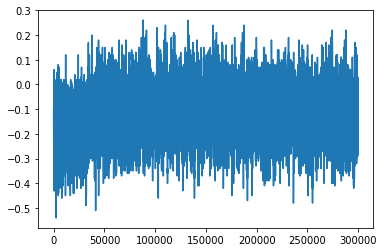

In [219]:
plt.plot(moving_average(gain, 100))

In [212]:
best_gain = -1
for lr in [0.00001, 0.0001, 0.001, 0.01, 0.1, 1]:
    for gamma in [0.2, 0.4, 0.6, 0.8, 1]:
        qlearningplayer = QLearningPlayer(env, lr, gamma)
        qlearningplayer.init_random_Q()
        gain = []
        eval_gain = []
        for _ in range(500000):
            states, actions, rewards = qlearningplayer.run_episode()
            gain.append(rewards[-1])
        for _ in range(100000):
            states, actions, rewards = qlearningplayer.evaluate_episode()
            eval_gain.append(rewards[-1])
        mean_gain = np.mean(eval_gain)
        print(f"LR: {lr}, Gamma: {gamma}, mean gain {mean_gain}")
        if mean_gain > best_gain:
            best_gamma = gamma
            best_lr = lr
            best_gain = mean_gain

KeyboardInterrupt: 

## Выводы пункт 1

Средний проигрыш наивного игрока 0.2 <br>
Средний проигрыш лучшего игрока (с параметрами lr=1e-05, gamma=0,8) 0.0636 <br>

# Пункт 2

In [257]:
class QDoublePlayer(BlackJackGamer):
    
    def __init__(self, env, lr, gamma) -> None:
        super(QDoublePlayer, self).__init__(env)
        self.Q = {}
        self.lr = lr
        self.gamma = gamma
        self.last_action = 0
        
    def init_random_Q(self):
        self.Q = {}
        for i in range(12):
            self.Q[i] = np.array([0, 1, 0])
        for i in range(22, 32):
            self.Q[i] = np.array([0, 0, 0])
        for i in range(12, 22):
            self.Q[i] = np.random.random(3)
        self.Q[21][2] = 0
        self.Q[21][1] = 0
        self.Q[21][0] = 1
        
    
    def run_episode(self):
        states, actions, rewards = [], [], []
        observation = self.env.reset()
        s, _, __ = observation 
        action = self.policy(observation)
        while True:
            states.append(s)        
            actions.append(action)
            observation, reward, done, info = self.new_step(action)
            s_prime, _, __ = observation
            a_prime = self.policy(observation)
            if s > 12 and s < 21:
                self.Q[s][action] = self.Q[s][action] + self.lr * (reward + self.gamma * np.max(self.Q[s_prime]) - self.Q[s][action])
            s, action = s_prime, a_prime
            rewards.append(reward)
            if done:
                return states, actions, rewards              
    
    def policy(self, observation, epsilon=0.1) -> int:
        score, dealer_score, usable_ace = observation
        if self.last_action == 2:
            action = 0
        else:
            if np.random.random() < epsilon:
                action = np.random.choice([0, 1, 2])
            else:
                action = np.argmax(self.Q[score])
        self.last_action = action
        return action
    
    def new_step(self, action):
        action_for_env = action if action != 2 else 1
        observation, reward, done, info = self.env.step(action_for_env)
        if action == 2:
            reward *= 2
        return observation, reward, done, info
    
    def evaluate_episode(self):
        states, actions, rewards = [], [], []
        observation = self.env.reset()
        while True:
            states.append(observation)
            action = self.policy(observation, 0)
            actions.append(action)
            observation, reward, done, info = self.new_step(action)
            rewards.append(reward)
            if done:
                return states, actions, rewards 

In [258]:
qdoubleplayer = QDoublePlayer(env, 0.0001, 0.8)
qdoubleplayer.init_random_Q()
gain = []
for _ in range(300000):
    states, actions, rewards = qdoubleplayer.run_episode()
    gain.append(rewards[-1])

In [260]:
gain_eval = []
for _ in range(100000):
    states, actions, rewards = qdoubleplayer.evaluate_episode()
    gain_eval.append(rewards[-1])

np.mean(gain_eval)

-0.11917

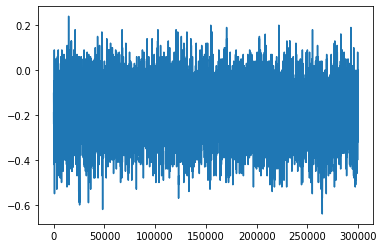

In [261]:
plt.plot(moving_average(gain, 100))

In [262]:
best_gain = -1
for lr in [0.00001, 0.0001, 0.001, 0.01, 0.1, 1]:
    for gamma in [0.2, 0.4, 0.6, 0.8, 1]:
        qdoubleplayer = QDoublePlayer(env, lr, gamma)
        qdoubleplayer.init_random_Q()
        gain = []
        eval_gain = []
        for _ in range(500000):
            states, actions, rewards = qdoubleplayer.run_episode()
            gain.append(rewards[-1])
        for _ in range(100000):
            states, actions, rewards = qdoubleplayer.evaluate_episode()
            eval_gain.append(rewards[-1])
        mean_gain = np.mean(eval_gain)
        print(f"LR: {lr}, Gamma: {gamma}, mean gain {mean_gain}")
        if mean_gain > best_gain:
            best_gamma = gamma
            best_lr = lr
            best_gain = mean_gain

KeyboardInterrupt: 

## Выводы пункт 2

Средний проигрыш лучшего игрока (с параметрами lr=0.001, gamma=0,2) 0.07762 <br>

# Пункт 3

В этот раз не получилось воспользоваться готовой средой, поэтому возьмем из задания. Для подсчета карт использовал стратегию  «Плюс-минус»  https://ru.wikipedia.org/wiki/%D0%91%D0%BB%D1%8D%D0%BA%D0%B4%D0%B6%D0%B5%D0%BA

In [263]:
def cmp(a, b):
    return float(a > b) - float(a < b)

class BlackjackDoubleCountingEnv(gym.Env):
    
    def __init__(self):
        self.plus_minus_count = {
            2: 1,
            3: 1,
            4: 1,
            5: 1,
            6: 1,
            7: 0,
            8: 0,
            9: 0,
            10: -1,
            11: -1,
        }
        self.action_space = spaces.Discrete(3)
        self.observation_space = spaces.Tuple((
            spaces.Discrete(32),
            spaces.Discrete(11),
            spaces.Discrete(2),
            spaces.Discrete(42)))
        self.seed()
        self.full_deck = [2, 3, 4, 5, 6, 7, 8, 9, 10, 10, 10, 10, 11] * 4
        self.deck = deepcopy(self.full_deck)
        self.count = 0
        self.reset()


    def seed(self, seed=None):
        self.np_random, seed = seeding.np_random(seed)
        return [seed]


    def step(self, action):
        assert self.action_space.contains(action)
        if action == 1:  # hit: add a card to players hand and return
            card = self.draw_card()
            self.count_card(card)
            self.player.append(card)
            if self.is_bust(self.player):
                done = True
                reward = -1.
            else:
                done = False
                reward = 0.
        elif action == 0:
            done = True
            while self.sum_hand(self.dealer) < 17:
                self.dealer.append(self.draw_card())
            for card in self.dealer[1:]:
                self.count_card(card)
            reward = cmp(self.score(self.player), self.score(self.dealer))

        elif action == 2:
            card = self.draw_card()
            self.count_card(card)
            self.player.append(card)
            done = True
            while self.sum_hand(self.dealer) < 17:
                self.dealer.append(self.draw_card())
            for card in self.dealer[1:]:
                self.count_card(card)
            reward = cmp(self.score(self.player), self.score(self.dealer)) * 2
            
        return self._get_obs(), reward, done, {}

    def _get_obs(self):
        return (self.sum_hand(self.player), self.dealer[0], False, self.count)
    
    def count_card(self, card):
        self.count += self.plus_minus_count[card] 

    def reset(self):
        if len(self.deck) < 15:
            self.deck = deepcopy(self.full_deck)
            self.count = 0
        self.dealer = self.draw_hand()
        self.count_card(self.dealer[0])
        self.player = self.draw_hand()
        self.count_card(self.player[0])
        self.count_card(self.player[1])
        return self._get_obs()
    
    def draw_card(self):
        card = np.random.choice(self.deck)
        self.deck.remove(card)
        return card


    def draw_hand(self):
        return [self.draw_card(), self.draw_card()]
    
    @staticmethod
    def sum_hand(hand):
        return sum(hand)
    
    def is_bust(self, hand):  # Is this hand a bust?
        return self.sum_hand(hand) > 21
    
    def score(self, hand):  # What is the score of this hand (0 if bust)
        return 0 if self.is_bust(hand) else self.sum_hand(hand)

In [264]:
custom_env = BlackjackDoubleCountingEnv()

In [265]:
custom_env.reset()

(15, 6, False, 1)

In [266]:
class QDustinPlayer(BlackJackGamer):
    
    def __init__(self, env, lr, gamma) -> None:
        super(QDustinPlayer, self).__init__(env)
        self.Q = {}
        self.lr = lr
        self.gamma = gamma
        self.last_action = 0
        
    def init_random_Q(self):
        self.Q = defaultdict(dict)
        for counter in range(-22, 23):
            for i in range(12):
                self.Q[counter][i] = np.array([0, 1, 0])
            for i in range(22, 32):
                self.Q[counter][i] = np.array([0, 0, 0])
            for i in range(12, 22):
                self.Q[counter][i] = np.random.random(3)
            self.Q[counter][21][2] = 0
            self.Q[counter][21][1] = 0
            self.Q[counter][21][0] = 1
        
    
    def run_episode(self):
        states, actions, rewards = [], [], []
        observation = self.env.reset()
        s, _, __, cnt = observation 
        action = self.policy(observation, cnt)
        while True:
            states.append(s)        
            actions.append(action)
            observation, reward, done, info = self.env.step(action)
            s_prime, _, __, cnt = observation
            a_prime = self.policy(observation, cnt)
            if s > 12 and s < 21:
                self.Q[cnt][s][action] = self.Q[cnt][s][action] + self.lr * (reward + self.gamma * np.max(self.Q[cnt][s_prime]) - self.Q[cnt][s][action])
            s, action = s_prime, a_prime
            rewards.append(reward)
            if done:
                return states, actions, rewards              
    
    def policy(self, observation, count, epsilon=0.1) -> int:
        score, dealer_score, usable_ace, _ = observation
        if score > 21:
            return 0
        if np.random.random() < epsilon:
            return np.random.choice([0, 1, 2]) 
        return np.argmax(self.Q[count][score])
    
    def evaluate_episode(self):
        states, actions, rewards = [], [], []
        observation = self.env.reset()
        while True:
            states.append(observation)
            action = self.policy(observation, observation[-1], 0)
            actions.append(action)
            observation, reward, done, info = self.env.step(action)
            rewards.append(reward)
            if done:
                return states, actions, rewards 
    

In [267]:
dustin = QDustinPlayer(custom_env, 0.0001, 0.4)

In [268]:
dustin.init_random_Q()

In [269]:
gain = []
for _ in range(100000):
    states, actions, rewards = dustin.run_episode()
    gain.append(rewards[-1])

In [270]:
gain_eval = []
for _ in range(100000):
    states, actions, rewards = dustin.evaluate_episode()
    gain_eval.append(rewards[-1])

np.mean(gain_eval)

-0.35078

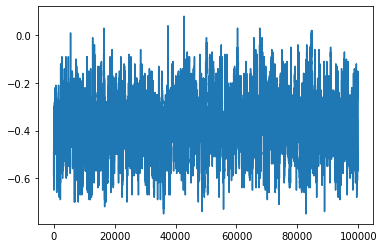

In [271]:
plt.plot(moving_average(gain, 100))

In [156]:
best_gain = -1
for lr in [0.00001, 0.0001, 0.001, 0.01, 0.1, 1]:
    for gamma in [0.2, 0.4, 0.6, 0.8, 1]:
        dustin = QDustinPlayer(custom_env, lr, gamma)
        dustin.init_random_Q()
        for _ in range(500000):
            states, actions, rewards = dustin.run_episode()
            gain.append(rewards[-1])
        mean_gain = np.mean(gain[-100000:])
        print(f"LR: {lr}, Gamma: {gamma}, mean gain {mean_gain}")
        if mean_gain > best_gain:
            best_gamma = gamma
            best_lr = lr
            best_gain = mean_gain

LR: 1e-05, Gamma: 0.2, mean gain -0.44777


KeyboardInterrupt: 

# end